In [1]:
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as web

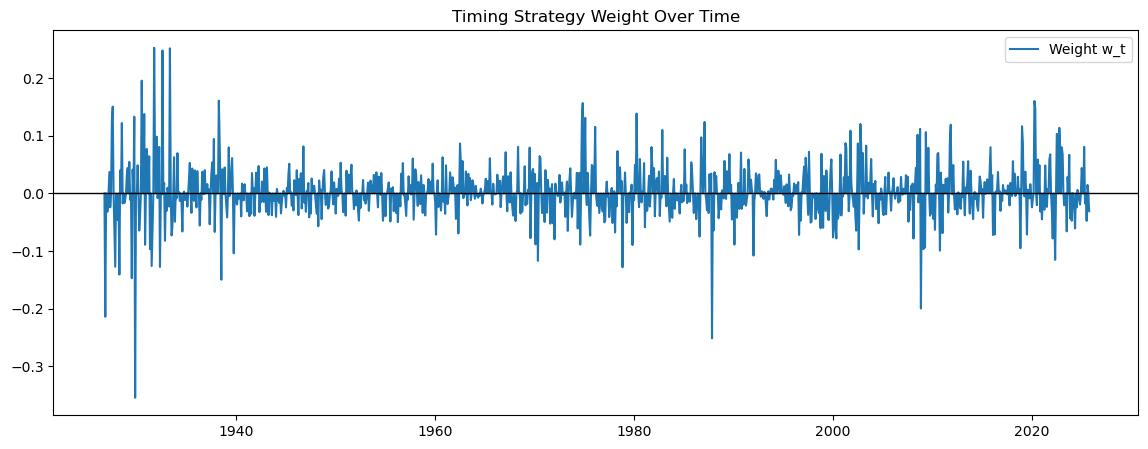

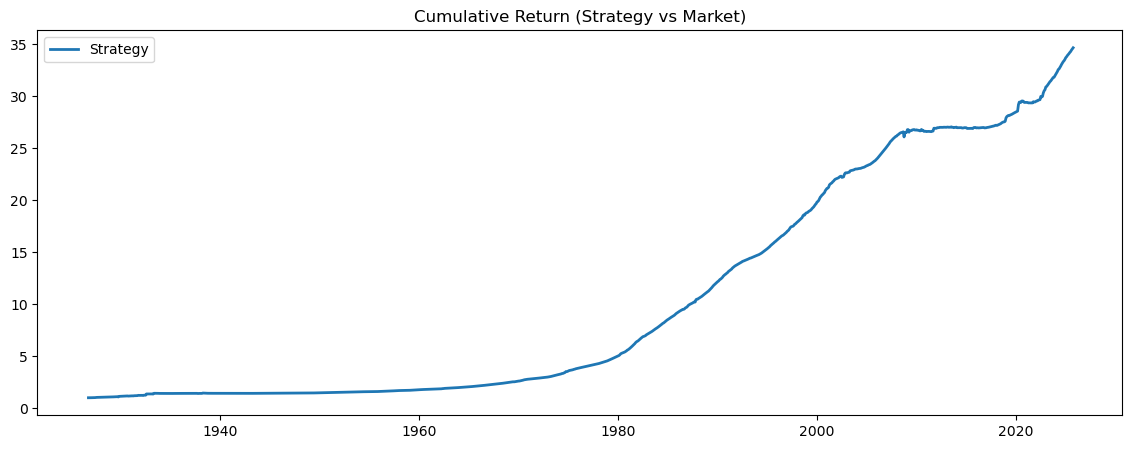


=== Correlation ===
All: 0.13396807319625115
N  : 0.01749957468746075
R  : 0.29379197459374196

=== Regression β, t-value (mkt ~ z) ===
ALL : β=0.1629, t=4.66
N   : β=0.0201, t=0.35
R   : β=0.2672, t=6.11


In [12]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm


# ======================================================================
# 1. Ken French 元ファイルから月次部分だけ抽出
# ======================================================================

def load_ff_monthly_from_ken_french(csv_path: str) -> pd.DataFrame:
    raw = pd.read_csv(csv_path, skiprows=4)

    num = pd.to_numeric(raw['Unnamed: 0'], errors='coerce')
    mask_monthly = num > 10000
    monthly = raw[mask_monthly].copy()

    monthly = monthly.rename(columns={'Unnamed: 0': 'date'})
    monthly['date'] = pd.to_datetime(monthly['date'].astype(int), format="%Y%m")
    monthly = monthly.set_index('date').sort_index()

    for col in ['Mkt-RF', 'RF']:
        monthly[col] = pd.to_numeric(monthly[col], errors='coerce')

    ff = monthly[['Mkt-RF', 'RF']].copy()
    ff['mkt_excess'] = ff['Mkt-RF'] / 100.0
    ff['rf'] = ff['RF'] / 100.0

    return ff[['mkt_excess', 'rf']].dropna()


# ======================================================================
# 2. 月タイプ分類
# ======================================================================

def classify_month_type(index):
    mt = pd.Series(index=index, dtype="object")
    for t in index:
        m = t.month % 3
        if m == 1:
            mt[t] = 'N'
        elif m == 2:
            mt[t] = 'R'
        else:
            mt[t] = '3'
    return mt


# ======================================================================
# 3. predictor z_t の構築
# ======================================================================

def build_predictor_z(ff):
    df = ff.copy()
    df["month_type"] = classify_month_type(df.index)

    df["mkt_lag"] = df["mkt_excess"].shift(1)
    df["mkt_mean_lag"] = df["mkt_excess"].expanding().mean().shift(1)
    df = df.dropna()

    base = df["mkt_lag"] - df["mkt_mean_lag"]

    z = []
    for mt, diff in zip(df["month_type"], base):
        if mt == "R":
            z.append(diff)
        elif mt == "N":
            z.append(-diff)
        else:
            z.append(0.0)
    df["z"] = z
    return df


# ======================================================================
# 4. タイミング戦略
# ======================================================================

def apply_timing_strategy(df, target_vol=0.05, max_leverage=3.0):
    out = df.copy()
    z = out["z"]

    weights = []
    sig_hist = []
    strat_excess = []
    strat_total = []
    mkt_total = []

    for i, t in enumerate(out.index):
        if i == 0:
            sigma = np.nan
            w = 0.0
        else:
            sigma = z.iloc[:i].std(ddof=1)
            if sigma is np.nan or sigma == 0:
                w = 0.0
            else:
                w = z.iloc[i] * target_vol / sigma
                w = float(np.clip(w, -max_leverage, max_leverage))

        weights.append(w)
        sig_hist.append(sigma)

        mkt = out.at[t, "mkt_excess"]
        rf = out.at[t, "rf"]
        se = w * mkt
        strat_excess.append(se)
        strat_total.append(rf + se)
        mkt_total.append(rf + mkt)

    out["w"] = weights
    out["sigma_z_hist"] = sig_hist
    out["strat_excess"] = strat_excess
    out["strat_total"] = strat_total
    out["mkt_total"] = mkt_total

    return out


# ======================================================================
# 5. 相関・回帰分析
# ======================================================================

def regression_summary(df):
    X = sm.add_constant(df["z"])
    y = df["mkt_excess"]
    model = sm.OLS(y, X).fit()
    return model.params["z"], model.tvalues["z"]


# ======================================================================
# 6. グラフ描画
# ======================================================================

def plot_results(df):
    plt.figure(figsize=(14,5))
    #plt.plot(df.index, df["w"], label="Weight w_t")
    plt.plot(df["w"], label="Weight w_t")
    plt.axhline(0, color="black", linewidth=1)
    plt.title("Timing Strategy Weight Over Time")
    plt.legend()
    plt.show()

    strat_wealth = (1 + df["strat_total"]).cumprod()
    mkt_wealth = (1 + df["mkt_total"]).cumprod()

    plt.figure(figsize=(14,5))
    plt.plot(strat_wealth, label="Strategy", linewidth=2)
    #plt.plot(mkt_wealth, label="Market", linewidth=2)
    plt.title("Cumulative Return (Strategy vs Market)")
    plt.legend()
    plt.show()


# ======================================================================
# 7. 実行
# ======================================================================

def main():
    ff = load_ff_monthly_from_ken_french("F-F_Research_Data_Factors.csv")
    df = build_predictor_z(ff)
    df = apply_timing_strategy(df)

    # ----------- グラフ表示 ------------
    plot_results(df)

    # ----------- 相関・回帰 ------------
    print("\n=== Correlation ===")
    print("All:", df["z"].corr(df["mkt_excess"]))
    print("N  :", df[df["month_type"]=="N"]["z"].corr(df[df["month_type"]=="N"]["mkt_excess"]))
    print("R  :", df[df["month_type"]=="R"]["z"].corr(df[df["month_type"]=="R"]["mkt_excess"]))

    print("\n=== Regression β, t-value (mkt ~ z) ===")
    beta_all, t_all = regression_summary(df)
    beta_N, t_N = regression_summary(df[df["month_type"]=="N"])
    beta_R, t_R = regression_summary(df[df["month_type"]=="R"])

    print(f"ALL : β={beta_all:.4f}, t={t_all:.2f}")
    print(f"N   : β={beta_N:.4f}, t={t_N:.2f}")
    print(f"R   : β={beta_R:.4f}, t={t_R:.2f}")


if __name__ == "__main__":
    main()


In [10]:
df

NameError: name 'df' is not defined

In [ ]:
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as web

# =========================================================
# 1) Fama-French 3 Factors (Monthly) をダウンロード
# =========================================================

def load_fama_french_3f_monthly():
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors.CSV"
    r = requests.get(url)
    r.raise_for_status()
    text = r.text

    df_raw = pd.read_csv(io.StringIO(text), skiprows=3)
    df_raw = df_raw.rename(columns={df_raw.columns[0]: "Date"})
    mask_monthly = df_raw["Date"].astype(str).str.strip().str.match(r"^\d{6}$")
    df_m = df_raw.loc[mask_monthly].copy()

    df_m["Date"] = pd.to_datetime(df_m["Date"].astype(str), format="%Y%m")
    df_m = df_m.set_index("Date")

    cols = ["Mkt-RF", "SMB", "HML", "RF"]
    df_m[cols] = df_m[cols].astype(float) / 100.0

    return df_m[cols]


# =========================================================
# 2) 月分類: カレンダー版 + ボラ版
# =========================================================

def classify_month_type_calendar(dates: pd.DatetimeIndex) -> pd.Series:
    month = dates.month
    types = pd.Series(index=dates, dtype="object")
    types[(month == 1) | (month == 4) | (month == 7) | (month == 10)] = "newsy"
    types[(month == 2) | (month == 5) | (month == 8) | (month == 11)] = "repetitive"
    types[(month == 3) | (month == 6) | (month == 9) | (month == 12)] = "third"
    return types


def classify_month_type_quarterly_vol(excess_ret: pd.Series) -> pd.Series:
    """
    四半期内の絶対超過リターンの大きさに基づいて
    newsy / repetitive / third を割り当てる。
    無料データのみで earnings intensity を近似する proxy。
    """
    excess_ret = excess_ret.sort_index()
    dates = excess_ret.index
    q = dates.to_period("Q")  # 四半期
    
    types = pd.Series(index=dates, dtype="object")
    
    for qi in q.unique():
        mask = q == qi
        sub_dates = dates[mask]
        if len(sub_dates) != 3:
            # サンプルの両端などで3ヶ月揃わない場合はカレンダーに fallback
            types.loc[sub_dates] = classify_month_type_calendar(sub_dates)
            continue
        
        sub_ret = excess_ret.loc[sub_dates]
        abs_ret = sub_ret.abs()
        rank = abs_ret.rank(ascending=False, method="first")
        
        for dt in sub_dates:
            if rank.loc[dt] == 1:
                types.loc[dt] = "newsy"
            elif rank.loc[dt] == 2:
                types.loc[dt] = "repetitive"
            else:
                types.loc[dt] = "third"
    
    return types


# =========================================================
# 3) 改良版 Predictor z_{t-1}
# =========================================================

def build_predictor_z_improved(
    excess_ret: pd.Series,
    use_vol_based_type: bool = True,
    mean_window: int = 120,
    std_window: int = 120,
) -> pd.Series:
    """
    改良版:
      - 四半期内ボラベースの month-type (オプション)
      - rolling mean & std (デフォルト 10年=120ヶ月)
      - z を std で標準化し、スケール安定化
    """
    excess_ret = excess_ret.sort_index()
    dates = excess_ret.index
    
    if use_vol_based_type:
        mtype = classify_month_type_quarterly_vol(excess_ret)
    else:
        mtype = classify_month_type_calendar(dates)

    # nr(t): newsy/repetitive の参照月
    nr_idx = pd.Series(index=dates, dtype="datetime64[ns]")

    for i, (dt, t_type) in enumerate(zip(dates, mtype)):
        if t_type == "repetitive":
            nr_idx.iloc[i] = dates[i - 1] if i >= 1 else pd.NaT
        elif t_type == "newsy":
            nr_idx.iloc[i] = dates[i - 2] if i >= 2 else pd.NaT
        else:
            nr_idx.iloc[i] = pd.NaT  # third

    # rolling mean & std (過去 mean_window ヶ月)
    mean_past = excess_ret.rolling(window=mean_window, min_periods=24).mean().shift(1)
    std_past = excess_ret.rolling(window=std_window, min_periods=24).std().shift(1)

    z_raw = pd.Series(index=dates, dtype="float64")
    z_raw[:] = 0.0

    for i, dt in enumerate(dates):
        t_type = mtype.iloc[i]
        if pd.isna(mean_past.iloc[i]) or pd.isna(nr_idx.iloc[i]):
            z_raw.iloc[i] = 0.0
            continue

        nr_date = nr_idx.iloc[i]
        mkt_nr = excess_ret.loc[nr_date]
        delta = mkt_nr - mean_past.iloc[i]

        if t_type == "repetitive":
            z_raw.iloc[i] = delta
        elif t_type == "newsy":
            z_raw.iloc[i] = -delta
        else:
            z_raw.iloc[i] = 0.0

    # std で標準化して scale を安定化（ただし third は 0 のまま）
    z_std = pd.Series(index=dates, dtype="float64")
    for i, dt in enumerate(dates):
        if std_past.iloc[i] is None or std_past.iloc[i] == 0 or np.isnan(std_past.iloc[i]):
            z_std.iloc[i] = 0.0
        else:
            z_std.iloc[i] = z_raw.iloc[i] / std_past.iloc[i]
    return z_std


# =========================================================
# 4) 戦略のバックテスト（改良版）
# =========================================================

def backtest_correlation_neglect_strategy_improved(
    excess_ret: pd.Series,
    rf_ret: pd.Series,
    target_vol_monthly: float = 0.05,
    max_leverage: float = 3.0,
    z_min: float = 0.2,
) -> pd.DataFrame:
    """
    改良版:
      - z を標準化したものを使う
      - |z| < z_min の月はトレードしない（ノイズ回避）
      - 残りは Vol targeting + truncate
    """
    excess_ret = excess_ret.sort_index()
    rf_ret = rf_ret.reindex_like(excess_ret)

    z_std = build_predictor_z_improved(excess_ret)

    # 小さい z は 0 にしてノイズ回避
    z_signal = z_std.copy()
    z_signal[np.abs(z_signal) < z_min] = 0.0

    # unscaled strategy return
    raw_ret = z_signal * excess_ret

    # 過去の raw ストラテジーのボラティリティ (t-1まで)
    hist_vol = raw_ret.expanding(min_periods=60).std().shift(1)

    w = pd.Series(index=excess_ret.index, dtype="float64")

    for i, dt in enumerate(excess_ret.index):
        if pd.isna(hist_vol.iloc[i]) or hist_vol.iloc[i] == 0:
            w.iloc[i] = 0.0
        else:
            w_i = z_signal.iloc[i] * (target_vol_monthly / hist_vol.iloc[i])
            w.iloc[i] = np.clip(w_i, -max_leverage, max_leverage)

    strat_excess = w * excess_ret
    strat_total = strat_excess + rf_ret

    result = pd.DataFrame(
        {
            "mkt_excess": excess_ret,
            "rf": rf_ret,
            "z_std": z_std,
            "z_signal": z_signal,
            "w": w,
            "strat_excess": strat_excess,
            "strat_total": strat_total,
        }
    )
    return result


# =========================================================
# 5) パフォーマンス集計
# =========================================================

def summarize_performance(returns: pd.Series, freq: int = 12) -> dict:
    r = returns.dropna()
    if len(r) == 0:
        return {}

    mean_m = r.mean()
    vol_m = r.std()

    ann_ret = (1 + mean_m) ** freq - 1
    ann_vol = vol_m * np.sqrt(freq) if vol_m > 0 else np.nan
    sharpe = mean_m / vol_m * np.sqrt(freq) if vol_m > 0 else np.nan

    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1
    max_dd = dd.min() if len(dd) > 0 else np.nan

    return {
        "ann_return": ann_ret,
            "ann_vol": ann_vol,
            "sharpe": sharpe,
            "max_drawdown": max_dd,
            "n_periods": len(r),
    }


# =========================================================
# 6) 実行例
# =========================================================

if __name__ == "__main__":
    ff = load_fama_french_3f_monthly()
    excess_ret = ff["Mkt-RF"]
    rf_ret = ff["RF"]

    # 期間はできれば長めに（例: 1965〜2024）
    start = "2000-01-01"
    end = "2024-12-31"
    excess_ret = excess_ret.loc[start:end]
    rf_ret = rf_ret.loc[start:end]

    # 改良版戦略
    res = backtest_correlation_neglect_strategy_improved(
        excess_ret, rf_ret,
        target_vol_monthly=0.05,
        max_leverage=3.0,
        z_min=0.2,
    )

    mkt_total = excess_ret + rf_ret
    perf_mkt = summarize_performance(mkt_total)
    perf_strat = summarize_performance(res["strat_total"])

    print("=== Market (Fama-French Mkt) ===")
    for k, v in perf_mkt.items():
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    print("\n=== Correlation-Neglect Strategy (Improved, free data only) ===")
    for k, v in perf_strat.items():
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    cum_mkt = (1 + mkt_total).cumprod()
    cum_strat = (1 + res["strat_total"]).cumprod()

=== Market (Fama-French Mkt) ===
ann_return: 0.0801
ann_vol: 0.1582
sharpe: 0.4885
max_drawdown: -0.5039
n_periods: 272

=== Correlation-Neglect Strategy (Improved, free data only) ===
ann_return: 0.0774
ann_vol: 0.1813
sharpe: 0.4125
max_drawdown: -0.3753
n_periods: 272


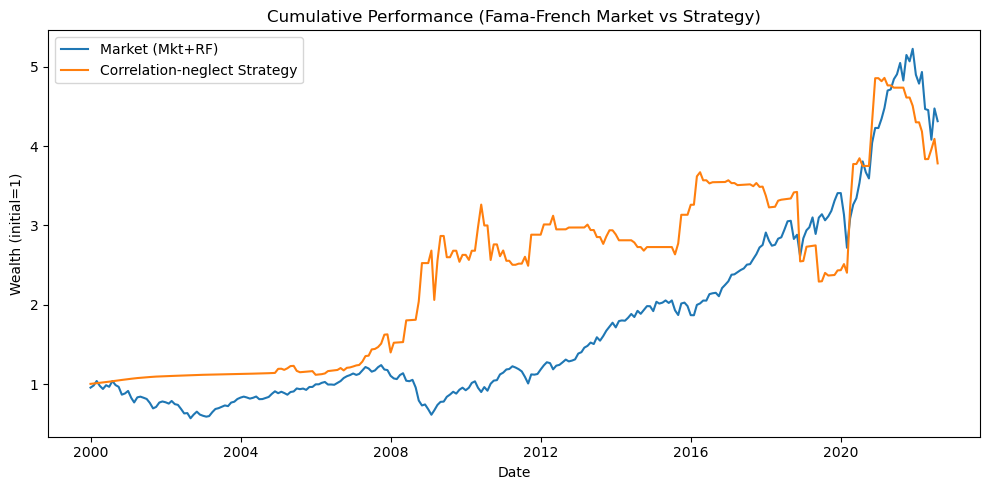

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(cum_mkt, label="Market (Mkt+RF)")
plt.plot(cum_strat, label="Correlation-neglect Strategy")
plt.legend()
plt.title("Cumulative Performance (Fama-French Market vs Strategy)")
plt.xlabel("Date")
plt.ylabel("Wealth (initial=1)")
plt.tight_layout()
plt.show()